# Tutorial 2: Plotting results
This is a tutorial for plotting various results after running a running a model with the Geomagnetic Field Inversions code written by Frenk Out, Maximilian Schanner, Liz van Grinsven, and Lennart de Groot.

### 0. Loading libraries
This tutorial requires, besides geomagnetic_field_inversions, numpy, pandas, pathlib, cartopy, and matplotlib.

In [2]:
import numpy as np
# Necessary for loading excel/csv files and creating DataFrames
import pandas as pd
# Necessary for correct path handling
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
# Cartopy is only required for plotting world maps
import cartopy.crs as ccrs

# Our code
from geomagnetic_field_inversions import InputData, FieldInversion, tools, forward_modules

First we will set-up a model to allow plotting

In [3]:
# Quickly load data
path = Path().absolute()
dataset = pd.read_csv(path / 'testdata.csv', index_col=0)
dataset = dataset.query('-2000 <= t <= 1990')
dataset.reset_index(inplace=True, drop=True)
dataset.loc[:, 'D'] /= 10
dataset.loc[:, 'dD'] /= 10
dataset.loc[:, 'I'] /= 10
dataset.loc[:, 'dI'] /= 10
inputdata = InputData(dataset)
# Create model
im = FieldInversion(t_min=-2000, t_max=1990, t_step=10, maxdegree=10)
im.prepare_inversion(inputdata, spat_type='ohmic_heating', temp_type='min_acc')
x0 = np.zeros(120)
x0[0] = -30000
im.run_inversion(x0, max_iter=5, spat_damp=1.0e-13, temp_damp=1.0e-3)

### 1. Plotting Results
After running the inversion, plots of the results can be retrieved to investigate what is going on in our model. For that purpose, we will plot residuals, Gauss coefficients, (damping) powerspectra, and global magnetic field maps.

In [4]:
# first some basic plotting tools
linestyles = ['solid', 'dotted', 'dashed', 'dashdot',
                  (0, (3, 5, 1, 5, 1, 5)), (0, (3, 10, 1, 10)), (0, (1, 10)),
                  (0, (3, 10, 1, 10, 1, 10))]
markerstyles = ['o', 's', '*', 'D', 'x']
colorstyles = ['black', 'grey', 'lightgrey']
# datatypes
dt = ['x', 'y', 'z', 'hor', 'inc', 'dec', 'int', 'all']

#### a) Residuals plots
Residual plots are ideal for observing the convergence rate of the inversion. Furthermore, the plot can show what datatype is fitted best. The figure shows in this case that after 2 iterations the residual seems stable.

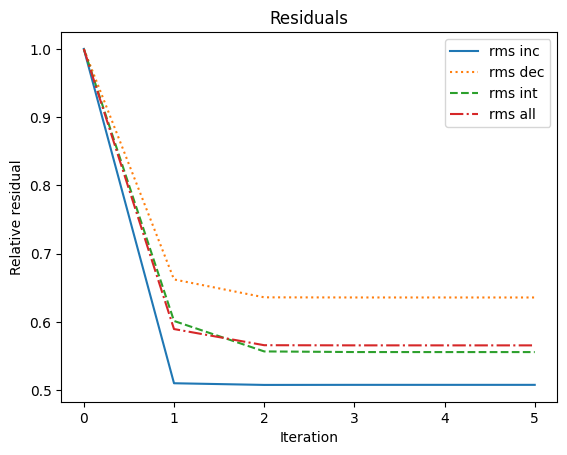

In [5]:
# We start by plotting the rms of various types per iteration
# start a figure
fig, ax = plt.subplots()
ax.set_title('Residuals')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative residual')
for i in range(8):
    if any(im.res_iter[:, i] > 0):
        ax.plot(np.arange(len(im.res_iter)),
                im.res_iter[:, i] / max(im.res_iter[:, i]),
                label=f'rms {dt[i]}', linestyle=linestyles[i-4])
        
ax.legend(loc='upper right')
plt.show()

#### b) Gauss coefficients
By plotting the Gauss coefficients, we can observe in a simple plot how the most important geomagnetic field features are changing through time. We decide to plot the Gauss coefficients of degree 1 together, but we could also decide something else by changing the `degree`-keyword.

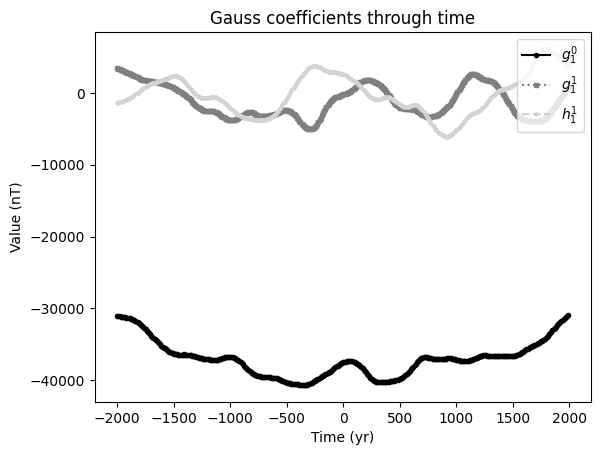

In [6]:
# with this keyword you can change the degree to be plotted
degree = 1

fig, ax = plt.subplots()
ax.set_title('Gauss coefficients through time')
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Value (nT)')
index = np.arange(degree**2, (degree+1)**2) - 1
labels = []
for deg in np.arange(1, degree+1):
    labels.append(f'$g^0_{deg}$')
    for m in np.arange(1, deg + 1):
        labels.extend([f'$g^{m}_{deg}$', f'$h^{m}_{deg}$'])

labels = [labels[i] for i in index]
for i, item in enumerate(index):
    ax.plot(im.t_array,
            im.unsplined_iter_gh[-1](im.t_array)[:, item],
            linestyle=linestyles[i % len(linestyles)],
            marker=markerstyles[i % len(markerstyles)],
            color=colorstyles[i % len(colorstyles)],
            markersize=3, label=labels[i])

ax.legend(loc='upper right')
plt.show()

We can also plot the Gauss coefficients per iteration, in order to observe convergence. We choose to observe at the final timestep.

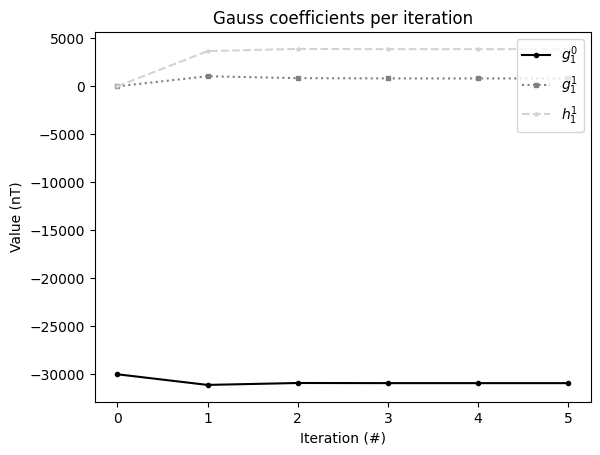

In [7]:
# choose here your timestep to observe
timestep = 399  # last timestep

fig, ax = plt.subplots()
ax.set_title('Gauss coefficients per iteration')
ax.set_xlabel('Iteration (#)')
ax.set_ylabel('Value (nT)')
for i, item in enumerate(index):
    coeff = np.zeros(len(im.unsplined_iter_gh) + 1)
    coeff[0] = im.x0[item]
    for c in range(len(coeff)-1):
        coeff[c+1] = im.unsplined_iter_gh[c](
            im.t_array[timestep])[item]
    ax.plot(np.arange(len(coeff)), coeff,
            linestyle=linestyles[i % len(linestyles)],
            marker=markerstyles[i % len(markerstyles)],
            color=colorstyles[i % len(colorstyles)],
            markersize=3, label=labels[i])
ax.legend(loc='upper right')
plt.show()

Already after 2 iterations, the Gauss coefficients are stable

#### c.1) Powerspectra
The powerspectrum allows us to observe the energy stored in the different Gauss coefficients, per degree, at the CMB. Ideally, this powerspectrum tends to zero for higher degrees. If not, then damping should be changed. Secular variation shows how the amount of energy stored in the time derivative of the Gauss coefficients per degree.

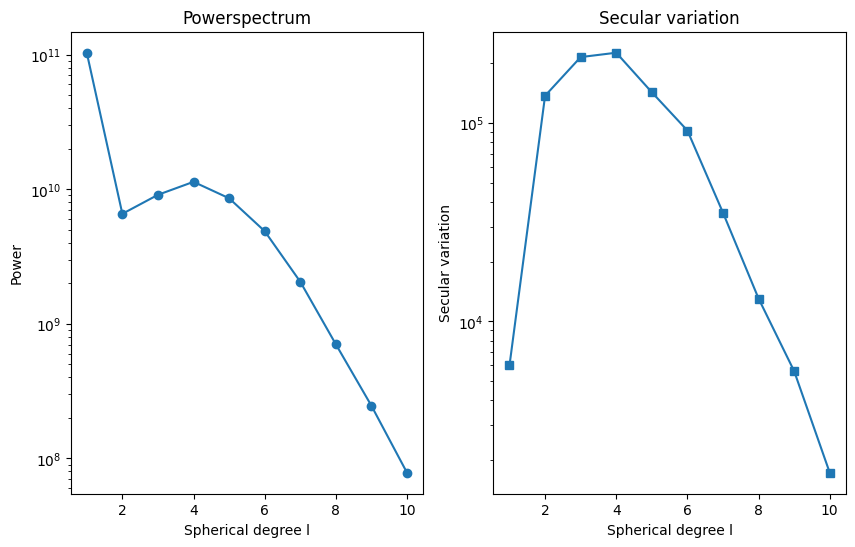

In [8]:
# start figure
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].set_title('Powerspectrum')
axes[0].set_xlabel('Spherical degree l')
axes[0].set_ylabel('Power')
axes[1].set_title('Secular variation')
axes[1].set_xlabel('Spherical degree l')
axes[1].set_ylabel('Secular variation')

sum_coeff_pow, sum_coeff_sv = tools.calc_spectra(
    im.splined_gh, im.maxdegree, im.t_step, cmb=True)

axes[0].plot(np.arange(1, im.maxdegree + 1), sum_coeff_pow,
             marker='o', label='power')
axes[1].plot(np.arange(1, im.maxdegree + 1), sum_coeff_sv,
             marker='s', label='variance')
axes[0].set_yscale('log')
axes[1].set_yscale('log')

plt.show()

#### c.2) damping norms
By plotting the spatial and temporal damping norms through time we can observe when damping was applied the most severly.

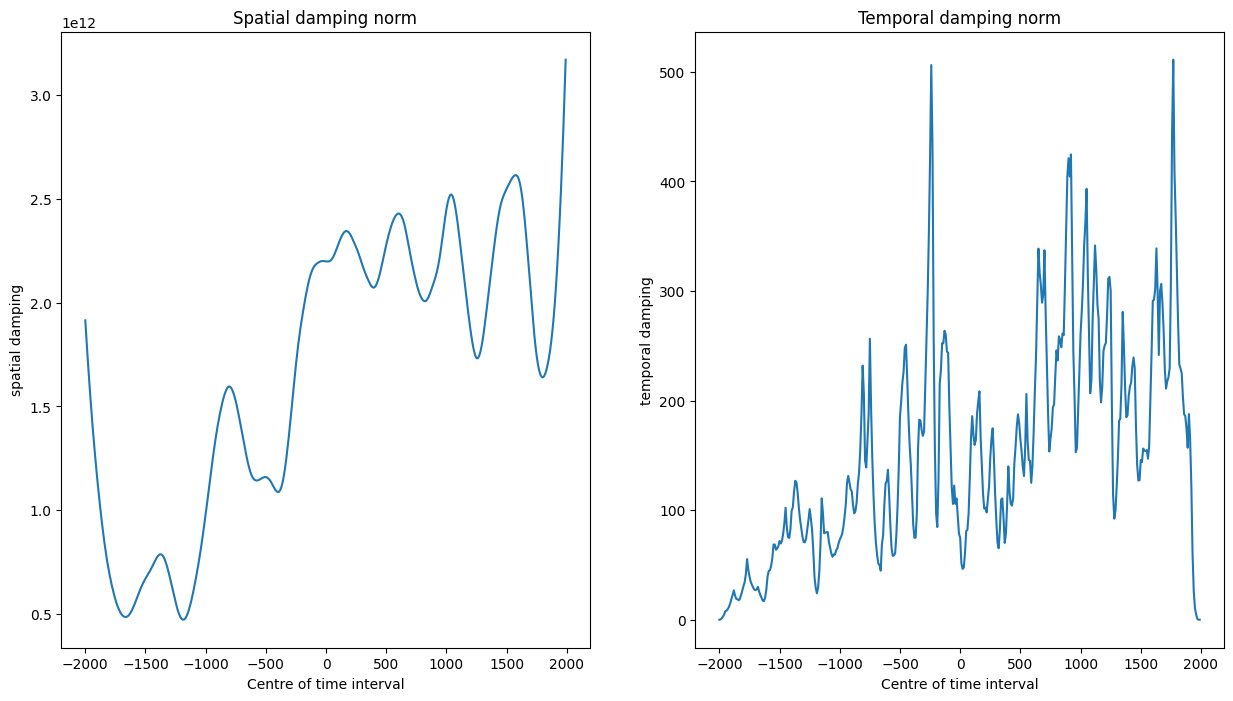

In [9]:
# start figure
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes[0].set_title('Spatial damping norm')
axes[0].set_xlabel('Centre of time interval')
axes[1].set_title('Temporal damping norm')
axes[1].set_xlabel('Centre of time interval')
t_s = len(im.t_array)
axes[0].plot(im.t_array, im.spat_norm[:t_s], label='spatial')
axes[0].set_ylabel('spatial damping')
axes[1].plot(im.t_array, im.temp_norm[:t_s], label='temporal')
axes[1].set_ylabel('temporal damping')
plt.show()

#### d) Global magnetic field maps
After calculation of the Gauss coefficients, we plot their effect on a worldmap. For the worldmap, we define 3 axes, choose a projection, and a time to plot by defining `time`. First, we plot the surface magnetic field.

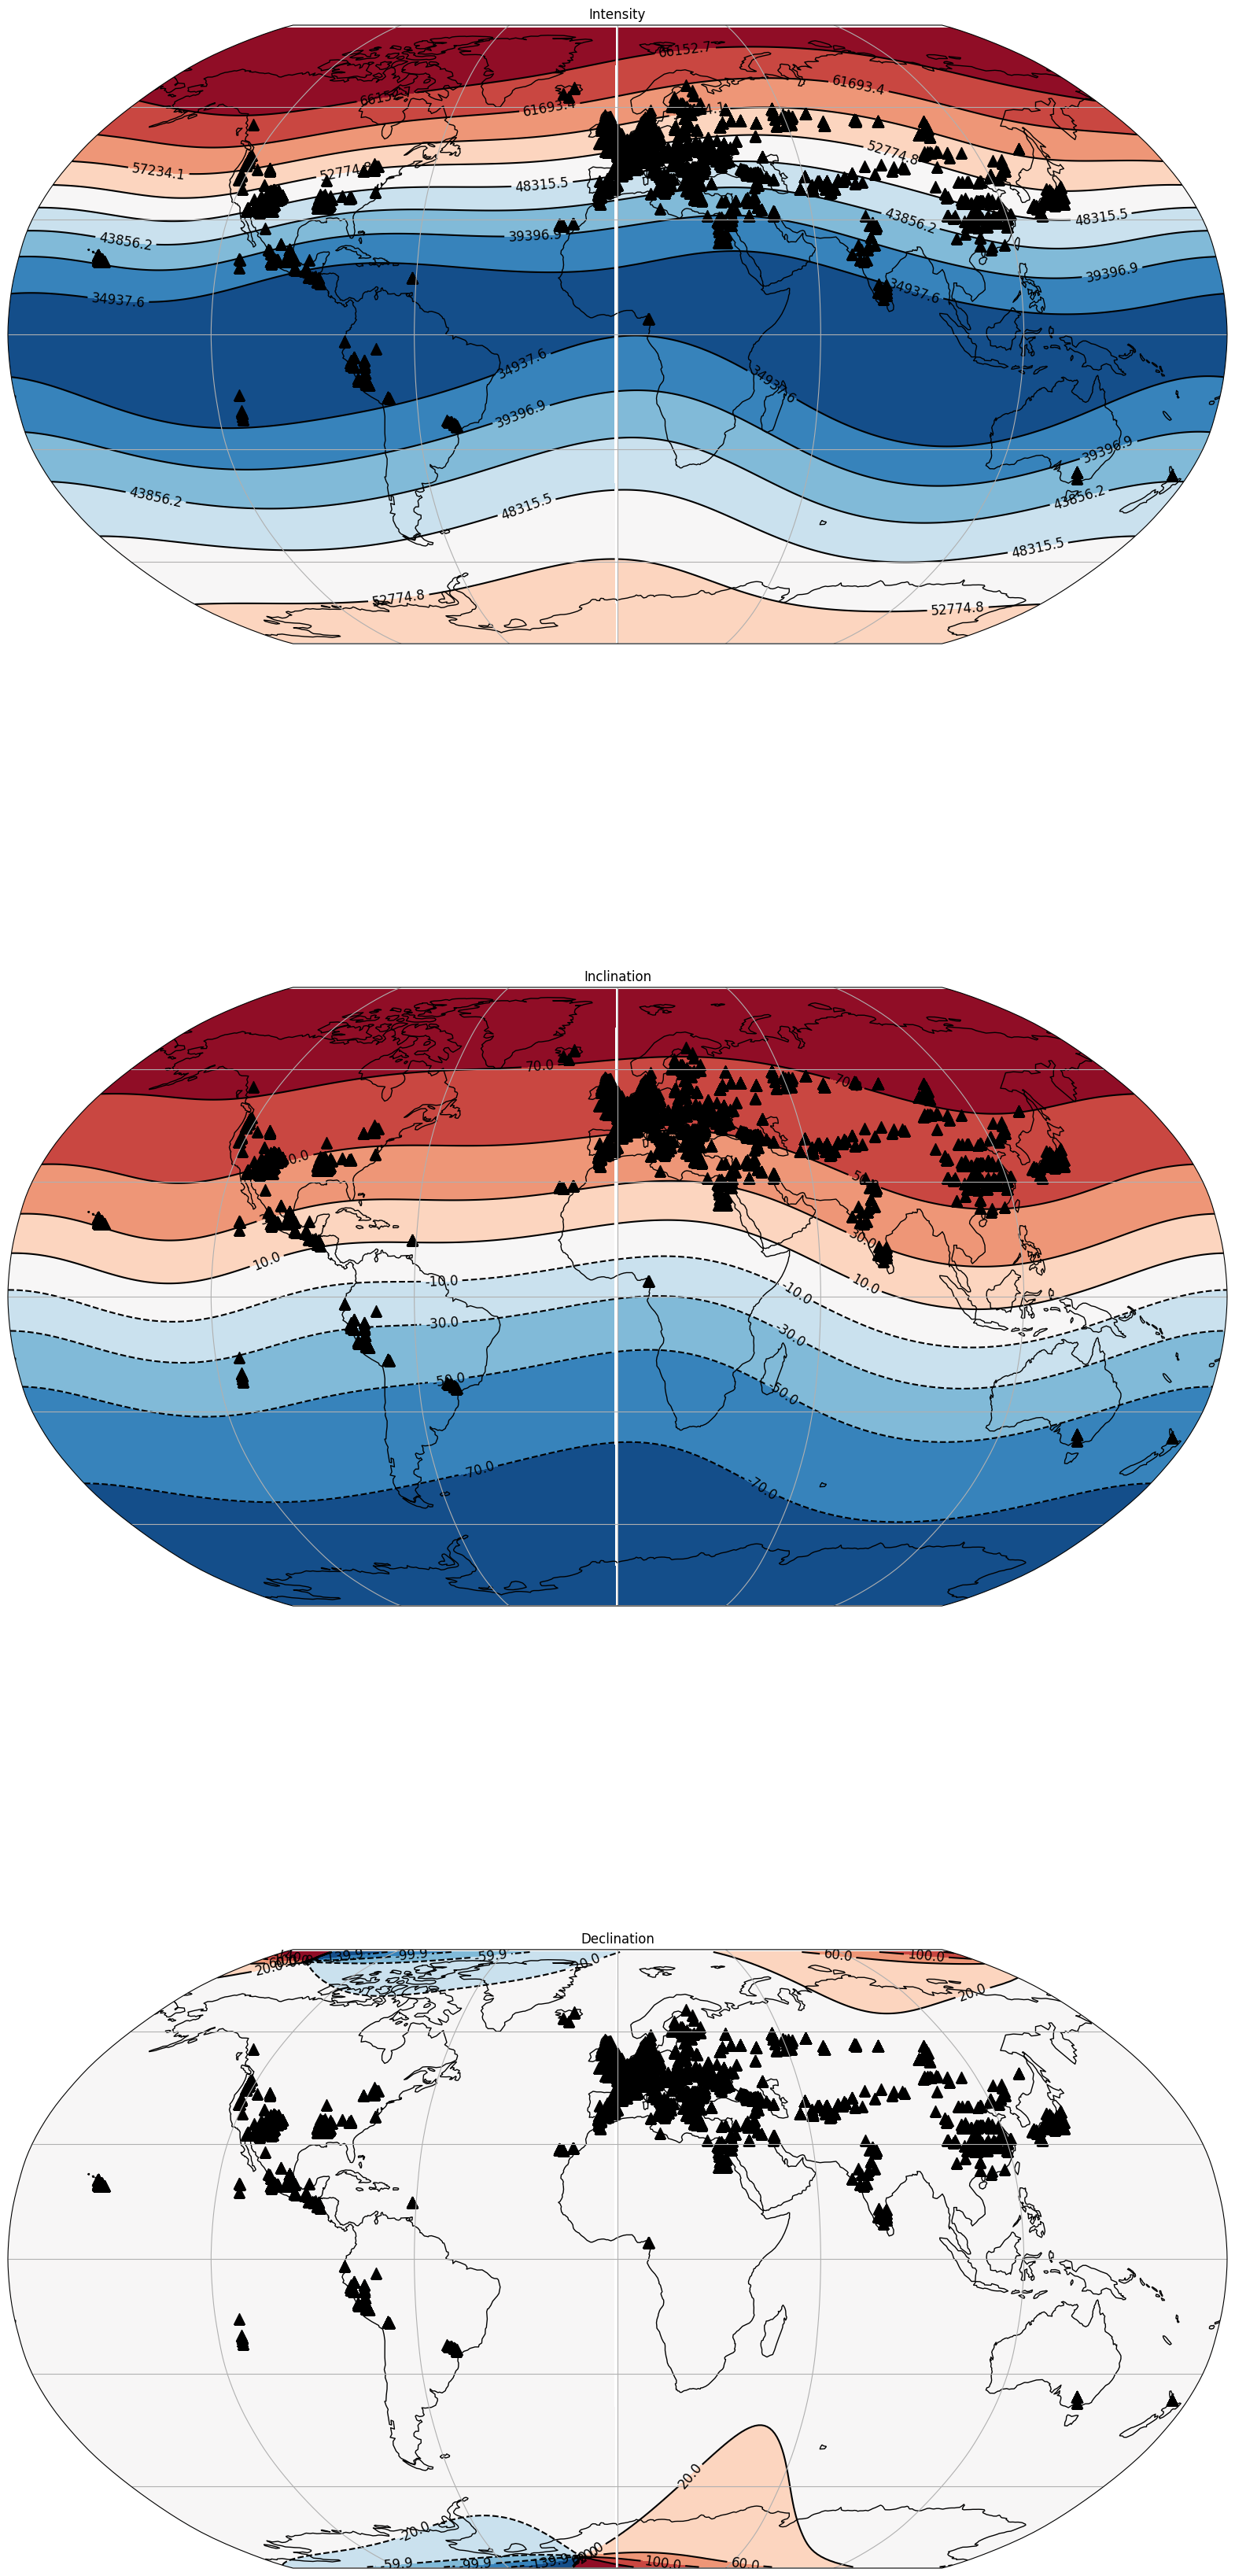

In [20]:
time = -2000
proj=ccrs.PlateCarree()

# set three axes and apply a Robinson world projection
fig, axes = plt.subplots(nrows=3, figsize=(20, 45), subplot_kw={'projection': ccrs.Robinson()})

coeff = im.unsplined_iter_gh[-1](time)[np.newaxis, :]
# make a grid of coordinates and apply forward model
forwlat = np.arange(-89, 89, 1)
forwlon = np.arange(0, 360, 1)
longrid, latgrid = np.meshgrid(forwlon, forwlat)
latgrid = latgrid.flatten()
longrid = longrid.flatten()
world_coord = np.zeros((len(latgrid), 3))
world_coord[:, 0] = np.radians(90 - latgrid)
world_coord[:, 1] = np.radians(longrid)
world_coord[:, 2] = 6371.2
fobs = forward_modules.calc_forw(im.maxdegree, world_coord, coeff,
                                 link=np.zeros(len(world_coord), dtype=np.int8))[4:]

title = ['Intensity', 'Inclination', 'Declination']
for i in range(3):
    axes[i].set_global()
    axes[i].contourf(forwlon, forwlat, fobs[i].reshape(178, 360),
                     cmap='RdBu_r', transform=proj,
                     levels=np.linspace(min(fobs[i]), max(fobs[i]), 10))
    c = axes[i].contour(forwlon, forwlat, fobs[i].reshape(178, 360),
                        levels=np.linspace(min(fobs[i]), max(fobs[i]), 10),
                        colors='k', transform=proj)
    axes[i].coastlines()
    axes[i].gridlines()
    axes[i].clabel(c, fontsize=12, inline=True, fmt='%.1f')
    axes[i].set_title(title[i])
    # plot station locations
    axes[i].scatter(dataset['lon'], dataset['lat'], transform=proj, color='black', marker='^', s=100)
plt.show()

But we can also plot the radial field at the CMB

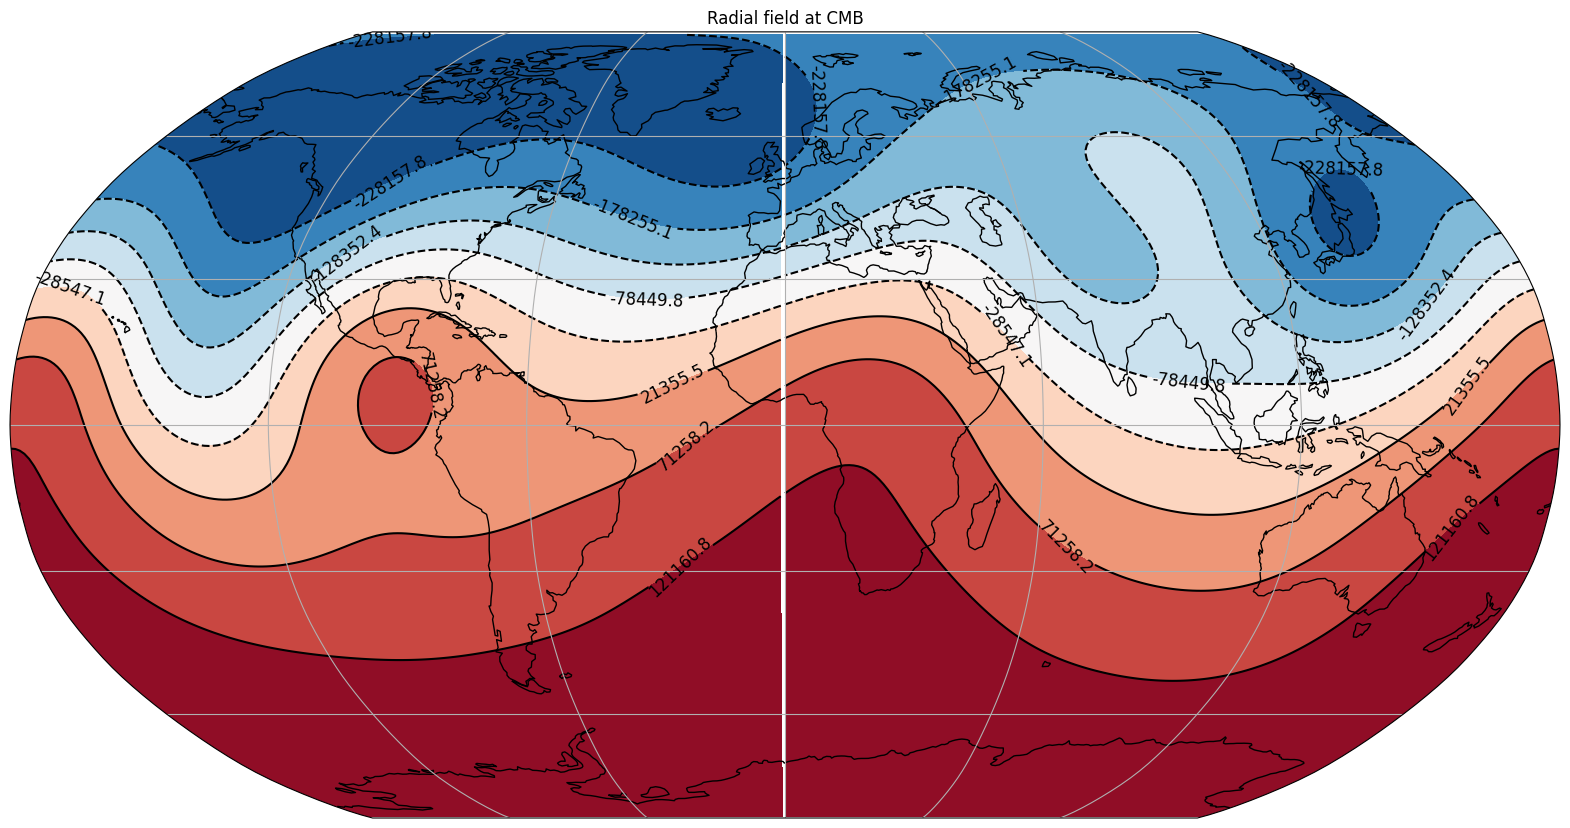

In [23]:
time = -2000
proj=ccrs.PlateCarree()

# set three axes and apply a Robinson world projection
fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.Robinson()})

coeff = im.unsplined_iter_gh[-1](time)[np.newaxis, :]
# now set radius to CMB
world_coord[:, 2] = 3485.0

fobs = -forward_modules.calc_forw(im.maxdegree, world_coord, coeff,
                                  link=np.zeros(len(world_coord), dtype=np.int8))[2]

ax.set_global()
ax.contourf(forwlon, forwlat, fobs.reshape(178, 360),
            cmap='RdBu_r', transform=proj,
            levels=np.linspace(min(fobs), max(fobs), 10))
c = ax.contour(forwlon, forwlat, fobs.reshape(178, 360),
               levels=np.linspace(min(fobs), max(fobs), 10),
               colors='k', transform=proj)
ax.coastlines()
ax.gridlines()
ax.clabel(c, fontsize=12, inline=True, fmt='%.1f')
ax.set_title('Radial field at CMB')

plt.show()

#### d*) longitude-versus-time plot
In case you want to see how magnetic field flux patches move around the CMB, you might want to use this plotting tool. We choose a latitude of 45 degrees

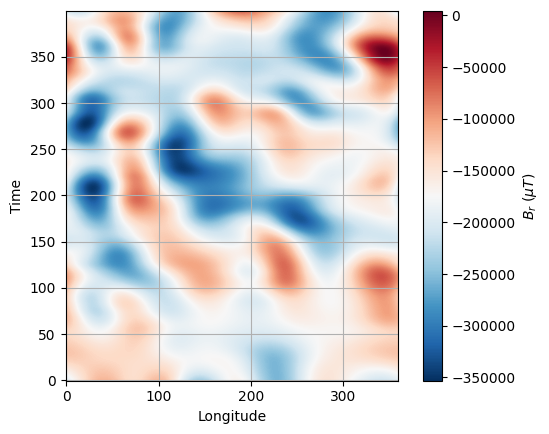

In [34]:
time = im.t_array
lat = 45

coeff = im.unsplined_iter_gh[-1](time)
forwlon = np.arange(0, 360, 1)
longrid, timegrid = np.meshgrid(forwlon, time)
longrid = longrid.flatten()
# make coordinates and link to gauss coefficients
world_coord = np.zeros((len(longrid), 3))
world_coord[:, 0] = np.radians(90 - lat)
world_coord[:, 1] = np.radians(longrid)
world_coord[:, 2] = 3485.0
link = np.tile(np.arange(len(time), dtype=np.int64), (len(forwlon), 1)).T.flatten()
# perform forward operation
forw_obs = forward_modules.calc_forw(im.maxdegree, world_coord, coeff, link=link)

fig, ax = plt.subplots()
ax.set_ylabel('Time')
ax.set_xlabel('Longitude')
c = ax.imshow(-1 * forw_obs[2].reshape(len(time), len(forwlon)),
              origin='lower', cmap='RdBu_r')
plt.grid(True)
plt.colorbar(c, label='$B_r$ ($\mu T$)')
plt.show()